In [2]:
from sklearn.feature_extraction.text import HashingVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [3]:
import matplotlib.pyplot as plt

In [4]:

def load_data():
    file = open("clean_fake.txt", "r")
    clean_fake_unprocessed = file.read()
    file.close()
    clean_fake_processed = clean_fake_unprocessed.split("\n")
    file = open("clean_real.txt", "r")
    clean_real_unprocessed = file.read()
    file.close()
    clean_real_processed = clean_real_unprocessed.split("\n")

    clean_combined = clean_fake_processed + clean_real_processed
    true_labels = [0] * len(clean_fake_processed) + [1] * len(clean_real_processed)

    vectorizer = CountVectorizer()
    clean_combined_vectorized = vectorizer.fit_transform(clean_combined)

    train_split = 0.7
    validation_split = 0.15
    test_split = 0.15

    x_train, x_test, y_train, y_test = train_test_split(clean_combined_vectorized, true_labels, test_size=1 - train_split)

    x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=test_split/(test_split + validation_split)) 

    return x_train, y_train, x_val, y_val, x_test, y_test, vectorizer

x_train, y_train, x_val, y_val, x_test, y_test, vectorizer = load_data()

Accuracy on validation set for tree1: 0.7020408163265306
Accuracy on validation set for tree2: 0.7306122448979592
Accuracy on validation set for tree3: 0.7612244897959184
Accuracy on validation set for tree4: 0.7816326530612245
Accuracy on validation set for tree5: 0.7816326530612245


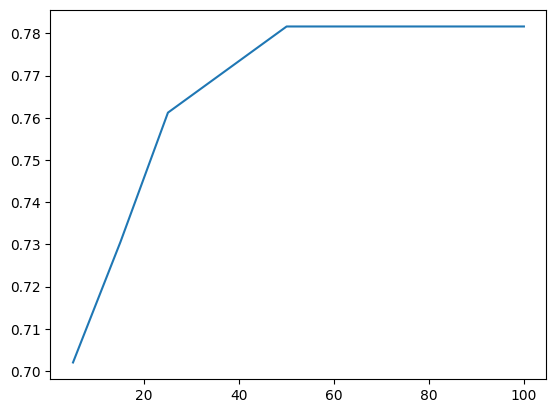

0.7291242362525459


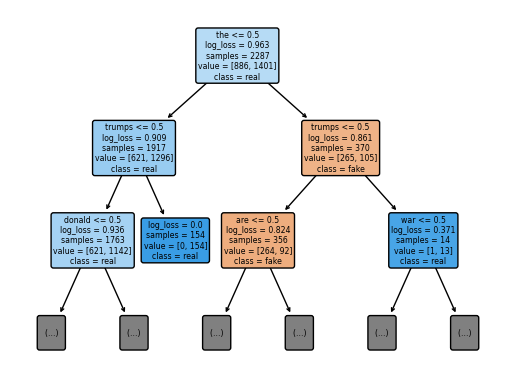

In [5]:
def select_model(x_train, y_train, x_val, y_val, x_test, y_test, vectorizer):
    max_depths = [5, 15, 25, 50, 100]
    # turns out i misread the prompt, its asking for 5 depths for each of the 3 criteria, not 5 depths total
    # but its almost the same thing so it doesnt really matter
    tree1 = DecisionTreeClassifier(criterion="gini", max_depth=max_depths[0], random_state=1)
    tree2 = DecisionTreeClassifier(criterion="entropy", max_depth=max_depths[1], random_state=1)
    tree3 = DecisionTreeClassifier(criterion="entropy", max_depth=max_depths[2], random_state=1)
    tree4 = DecisionTreeClassifier(criterion="log_loss", max_depth=max_depths[3], random_state=1)
    tree5 = DecisionTreeClassifier(criterion="log_loss", max_depth=max_depths[4], random_state=1)

    tree1.fit(x_train, y_train)
    tree2.fit(x_train, y_train)
    tree3.fit(x_train, y_train)
    tree4.fit(x_train, y_train)
    tree5.fit(x_train, y_train)

    tree1_on_val = tree1.predict(x_val) == y_val
    tree2_on_val = tree2.predict(x_val) == y_val
    tree3_on_val = tree3.predict(x_val) == y_val
    tree4_on_val = tree4.predict(x_val) == y_val
    tree5_on_val = tree5.predict(x_val) == y_val

    acc1 = sum(tree1_on_val)/len(y_val)
    acc2 = sum(tree2_on_val)/len(y_val)
    acc3 = sum(tree3_on_val)/len(y_val)
    acc4 = sum(tree4_on_val)/len(y_val)
    acc5 = sum(tree5_on_val)/len(y_val)

    print("Accuracy on validation set for tree1: " + str(acc1))
    print("Accuracy on validation set for tree2: " + str(acc2))
    print("Accuracy on validation set for tree3: " + str(acc3))
    print("Accuracy on validation set for tree4: " + str(acc4))
    print("Accuracy on validation set for tree5: " + str(acc5))
    
    depth_v_accuracy = [acc1, acc2, acc3, acc4, acc5]

    tree4_test_acc = sum(tree4.predict(x_test) == y_test)/len(y_test)

    return max_depths, depth_v_accuracy, tree4_test_acc, tree4

max_depths, depth_v_accuracy, tree4_test_acc, tree4 = select_model(x_train, y_train, x_val, y_val, x_test, y_test, vectorizer)

plt.plot(max_depths, depth_v_accuracy)
plt.show()
print(tree4_test_acc)

from sklearn import tree

tree.plot_tree(tree4, max_depth=2, feature_names=vectorizer.get_feature_names_out().tolist(), class_names=["fake", "real"], filled=True, rounded=True)
plt.show()



In [6]:
from math import log2

In [27]:
def compute_information_gain(y, xi, doprint=False):
    # so far, i think y is the tree and xi is the feature/ raw word
    # real_word = vectorizer.transform([xi])

    n_nodes = y.tree_.node_count
    children_left = y.tree_.children_left
    children_right = y.tree_.children_right
    feature = y.tree_.feature
    threshold = y.tree_.threshold
    values = y.tree_.value
    n_node_samples = y.tree_.n_node_samples

    stack = [(0, 0)]
    while len(stack) > 0:
        node_id, depth = stack.pop()
        is_split_node = children_left[node_id] != children_right[node_id]
        if is_split_node:
            if vectorizer.get_feature_names_out()[feature[node_id]] == xi:
                if doprint:
                    print("found the word at node id " + str(node_id))

                # information gain is H(Y) - H(Y|X)
                # how to get H(Y), - sum y in Y p(y) log_2 p(y) CHECK
                # how to get H(Y|X), - sum x in X p(x) sum y in Y p(y|x) log_2 p(y|x)
                # how to get p(y), fraction of y / all samples
                # how to get p(y|x), fraction of y / all samples where x is true
                # or just p(y and x)/p(x). issue is that x is just one value, not cloudy/not cloudy like we saw before

                # ah misconception here is that X is the words that are actually this threshold
                # if not, they go to the other side of the tree, those are my two Xs
                # then i can find the correct H(Y) and H(Y|X) for this node

                total_samples = values[node_id][0][0] + values[node_id][0][1]

                prob_of_y0 = values[node_id][0][0]/n_node_samples[node_id]
                prob_of_y1 = values[node_id][0][1]/total_samples

                epsilon = 1e-8  # small epsilon value


                # entropy_of_Y = - prob_of_y0 * log2(prob_of_y0) - prob_of_y1 * log2(prob_of_y1)
                entropy_of_Y = - (prob_of_y0 * log2(prob_of_y0 + epsilon)) - (prob_of_y1 * log2(prob_of_y1 + epsilon))

                if doprint:
                    print(entropy_of_Y)
                    print("above is entropy of Y ------")
                # now i need to find the entropy of Y|X

                # first for the right children where the word does infact indeed for sure come up

                total_samples_right = values[children_right[node_id]][0][0] + values[children_right[node_id]][0][1]
                prob_of_y0_condition_x1 = values[children_right[node_id]][0][0]/n_node_samples[children_right[node_id]]
                prob_of_y1_condition_x1 = values[children_right[node_id]][0][1]/total_samples_right

                # now for the left children where the word does not come up

                total_samples_left = values[children_left[node_id]][0][0] + values[children_left[node_id]][0][1]
                prob_of_y0_condition_x0 = values[children_left[node_id]][0][0]/n_node_samples[children_left[node_id]]
                prob_of_y1_condition_x0 = values[children_left[node_id]][0][1]/total_samples_left

                if doprint:
                    print("total samples" + str(total_samples))
                prob_x1 = total_samples_right/total_samples
                prob_x0 = total_samples_left/total_samples

                # print(prob_of_y0_condition_x0, prob_of_y0_condition_x1, prob_of_y1_condition_x0, prob_of_y1_condition_x1)

                # epsilon for log2(0) prevention
                entropy_of_Y_given_X = - (prob_x0 * ((prob_of_y0_condition_x0 * log2(prob_of_y0_condition_x0 + epsilon)) + (prob_of_y1_condition_x0 * log2(prob_of_y1_condition_x0 + epsilon)))) - (prob_x1 * ((prob_of_y0_condition_x1 * log2(prob_of_y0_condition_x1 + epsilon)) + (prob_of_y1_condition_x1 * log2(prob_of_y1_condition_x1 + epsilon))))

                # entropy_of_Y_given_X = - (prob_x0 * (prob_of_y0_condition_x0 * log2(prob_of_y0_condition_x0) + prob_of_y1_condition_x0 * log2(prob_of_y1_condition_x0))) - (prob_x1 * (prob_of_y0_condition_x1 * log2(prob_of_y0_condition_x1) + prob_of_y1_condition_x1 * log2(prob_of_y1_condition_x1)))

                if doprint:
                    print(entropy_of_Y_given_X)
                    print("INFORMATION GAIN IS " + str(entropy_of_Y - entropy_of_Y_given_X))
                    print("------------------")

                    # word is not there!
                    print(values[children_left[node_id]])

                    # if the word is indeed there, go to right, [17, 0] means there are 17 fake and 0 real if the word hillary is there
                    # cool!
                    print(values[children_right[node_id]])

                return entropy_of_Y - entropy_of_Y_given_X
            stack.append((children_left[node_id], depth + 1))
            stack.append((children_right[node_id], depth + 1))
    
print(compute_information_gain(tree4, "the"))
print(compute_information_gain(tree4, "trumps"))
print(compute_information_gain(tree4, "donald"))
print(compute_information_gain(tree4, "hillary"))
print(compute_information_gain(tree4, "landslide")) # exaggerated words helps us ascertain if its fake or not by a LOT (0.918)

0.06226310560211046
0.05333753757448867
0.04856081856750838
0.024079244842575953
0.9182958196275393


In [9]:
import numpy as np
output = vectorizer.transform(["the"]).toarray()

nonzero_indices = np.nonzero(output)[1]
print(nonzero_indices)
print(output[0][nonzero_indices[0]])

# vectorizer.inverse_transform(output)[0].tolist()[0]
vectorizer.get_feature_names_out()[nonzero_indices].tolist()

[5143]
1


['the']